# Overview:

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 


# Evaluation Metric

Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as


RMSPE= sqrt( 1/n ∑i=1:n (yi−y^i/yi)2 )

where y_i denotes the sales of a single store on a single day and yhat_i denotes the corresponding prediction. Any day and store with 0 sales is ignored in scoring.



# Data Description

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

# Files

train.csv - historical data including Sales
test.csv - historical data excluding Sales
store.csv - supplemental information about the stores


# Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [132]:
# Import Libraries

import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
# Setting up PATH to import xgboost
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

In [133]:
#Utility functions to calculate Root Mean Square Percentage Error - Source: Chenglong Chen - Kaggle forums

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [134]:
# Load train, test and store datasets
os.chdir('C:\\LUML\\Kaggle\\Rossmann')
train = pd.read_csv("train.csv")
store  = pd.read_csv("store.csv")
test   = pd.read_csv("test.csv")

C:\Python3.5\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Exploration

Data Exploration for this dataset is mentioned in the following notebook
https://github.com/chaitu1385/RossmannKaggle/blob/master/Data-Exploration/Rossmann%20Stores%20Forecasting.ipynb

# Data Preprocessing and Feature Engineering

In [135]:
# Convert Date column from object to datetime and sort train and test data based on date

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train = train.sort_values(by = 'Date')
test = test.sort_values(by = 'Date')


# There are few stores that are having null values in test set. 
#It is better to assume the store is open. If it's closed then sales will be 0 and it won't count toward the score. 
# But if it's open and we predict 0 then we're in for some heavy penalty.
test[test['Open'].isnull()]
test['Open'] = test['Open'].fillna(1) 

In [136]:
# Create a variable to differentiate train and test 
train['Set'] = 1
test['Set'] = 0

In [137]:
# Combine train and test data
frames = [train, test]
df = pd.concat(frames)

In [138]:
# Check columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 1017208 to 0
Data columns (total 11 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058297 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 96.9+ MB


In [139]:
### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [140]:
# convert the sales to log(sales) in order to be not sensitive to outliers
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales'])

In [141]:
# StateHoliday column has values 0 & "0", So, we need to merge values with 0 to "0"
#df["StateHoliday"].loc[df["StateHoliday"] == 0] = "0"

# Label encoding
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes
store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes

In [142]:
# Create time based features - important for time series data

df['Day'] = pd.Index(df['Date']).day
df['Week'] = pd.Index(df['Date']).week
df['Month'] = pd.Index(df['Date']).month
df['Year'] = pd.Index(df['Date']).year
df['DayOfYear'] = pd.Index(df['Date']).dayofyear

df['Day'] = df['Day'].fillna(0)
df['Week'] = df['Week'].fillna(0)
df['Month'] = df['Month'].fillna(0)
df['Year'] = df['Year'].fillna(0)
df['DayOfYear'] = df['DayOfYear'].fillna(0)

# Initial feature set for the model
features = ['Store', 'Day', 'Week', 'Month','Year','DayOfYear', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
label = ['SalesLog']

In [143]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [144]:
# Append CompetitionOpenSinceYear and CompetitionOpenSinceMonth into one column

def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

store['CompetitionOpenSince'] = store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [145]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
CompetitionOpenSince           int64
dtype: object

In [146]:
# Append Promo2SinceYear and Promo2SinceWeek into one column

def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

store['Promo2Since'] = store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [147]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
CompetitionOpenSince           int64
Promo2Since                    int64
dtype: object

In [148]:
s = store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
store = store.join(s)

In [149]:
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

store['PromoInterval0'] = store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['PromoInterval1'] = store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['PromoInterval2'] = store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['PromoInterval3'] = store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
del store['PromoInterval']

In [150]:
# Create aggregated features that are unique to the store
# Average Sales per day for each store
# Average Customers per day for each store
# Average Sales per Customer per day
total_sales = df.groupby([df['Store']])['Sales'].sum()
total_customers = df.groupby([df['Store']])['Customers'].sum()
open_stores = df.groupby([df['Store']])['Open'].count()

avg_sales_per_day = total_sales / open_stores
avg_customers_per_day = total_customers / open_stores
avg_sales_per_customer_per_day = avg_sales_per_day / avg_customers_per_day

In [151]:
store = pd.merge(store, avg_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
store = pd.merge(store, avg_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
store = pd.merge(store, avg_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])


In [152]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
CompetitionOpenSince           int64
Promo2Since                    int64
PromoInterval0               float64
PromoInterval1               float64
PromoInterval2               float64
PromoInterval3               float64
SalesPerDay                  float64
CustomersPerDay              float64
SalesPerCustomersPerDay      float64
dtype: object

In [153]:
store_features = ['Store', 'StoreType', 'Assortment', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay',
                  'CompetitionDistance', 'CompetitionOpenSince','Promo2Since', 'PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3']

features = list(set(features + store_features))
df = pd.merge(df, store[store_features], how='left', on=['Store'])

In [154]:
# Convert all NAN to -1
for feature in features:
    df[feature] = df[feature].fillna(-1)

In [155]:
# split the train data into train and test sets
seed = 50
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) ][features],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) ][label],
                                                    test_size=0.1, random_state=seed)

In [156]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [157]:
evallist = [(dtrain, 'train'), (dtest, 'test')]


params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.85,
          "colsample_bytree": 0.4,
          "min_child_weight": 6,
          "silent": 1,
          "thread": 4,
          "seed": seed
          }
num_boost_round = 5000

model = xgb.train(plst, dtrain, num_boost_round, evallist, feval=rmspe_xg, verbose_eval=True, early_stopping_rounds=200)

[0]	train-rmse:5.79065	test-rmse:5.79086	train-rmspe:0.996895	test-rmspe:0.996898
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 200 rounds.
[1]	train-rmse:4.05624	test-rmse:4.05623	train-rmspe:0.981974	test-rmspe:0.981979
[2]	train-rmse:2.84349	test-rmse:2.84336	train-rmspe:0.939586	test-rmspe:0.939548
[3]	train-rmse:1.99594	test-rmse:1.99582	train-rmspe:0.859756	test-rmspe:0.859456
[4]	train-rmse:1.40411	test-rmse:1.40403	train-rmspe:0.748417	test-rmspe:0.747179
[5]	train-rmse:0.992467	test-rmse:0.99239	train-rmspe:0.62358	test-rmspe:0.620063
[6]	train-rmse:0.706769	test-rmse:0.706679	train-rmspe:0.504193	test-rmspe:0.496792
[7]	train-rmse:0.511278	test-rmse:0.511286	train-rmspe:0.406019	test-rmspe:0.391574
[8]	train-rmse:0.379672	test-rmse:0.379826	train-rmspe:0.334658	test-rmspe:0.311136
[9]	train-rmse:0.293873	test-rmse:0.294135	train-rmspe:0.289436	test-rmspe:0.255966
[10]	train-rmse:0.2398	tes

In [158]:
# Predictions on the test set

X_submit = df.loc[df['Set'] == 0]
dsubmit = xgb.DMatrix(X_submit[features])

In [159]:
ypred_bst = model.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

df_ypred['Sales'] = (np.exp(ypred_bst) - 1)

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_submission.csv', index=False)

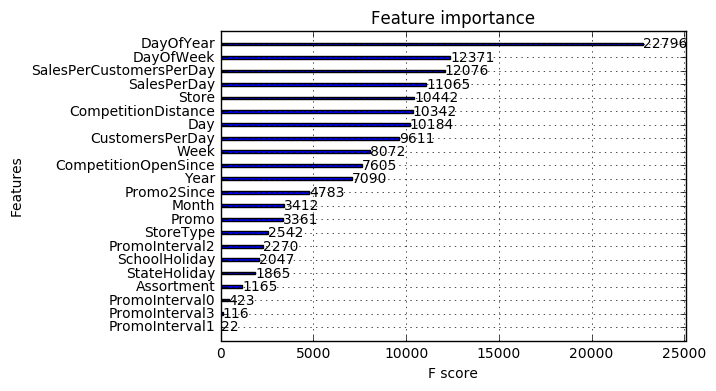

In [160]:
# Feature importance plot from XGBoost
xgb.plot_importance(model)

# Future Work

- Do a Grid Search of Parameters and Feature Selection - It is very computational Intensive but we can do it once to get the best parameters and features combination to get the model with lowest RMSPE.
- Check if there are any outliers in each store and check the methodologies to correct and test the above approach
- So far, the algorithms tried are Decision tree (for intrepretability), randomForest and XGBoost. XGBoost is fast as well as it gave best results. I would like to try neural networks as well to see how it performs on this dataset.
- Solve this problem using time series approach instead of machine learning approach as we have enough data to capture trend and seasonality.